# Data mining \& clustering

The goal if this practical is to adress the folowing problem: 
<center style="color:red" >  Given XXX raw, unlabeled documents, ... How to exploit/understand/represent them?</center>

In the previous week, we have seen how to represent textual data with the Bag of Words (BoW) model:
$$X = 
	\begin{matrix} 
	 & \textbf{t}_j \\
	 & \downarrow \\
	\textbf{d}_i \rightarrow &
	\begin{pmatrix} 
	x_{1,1} & \dots & x_{1,d} \\
	\vdots & \ddots & \vdots \\
	x_{N,1} & \dots & x_{N,d} \\
	\end{pmatrix}
	\end{matrix}
	$$

From this BoW representation, we want to answer the following questions:
1. Which clustering algorithm to choose?
    - K-means, LSA, pLSA, LDA
1. What results to expect?
    - Semantics, noise cleaning, etc...
1. Which qualitative and quantitative analyses to understand the groups?
[comment]: <> (%1. Comment boucler, itérer pour améliorer la qualité du processus?)


<span style="color:magenta" > In this practical, we use a **labeled dataset** in order to evaluate performances with quantitative and well-defined metrics. </span>


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path
import sklearn

## Data loading



In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [3]:
# conversion BoW + tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer() 
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)

# sparsity measure = 44 active words over 1000 per document (157 over 130000) !!
print(vectors.nnz / float(vectors.shape[0]))

(11314, 1000)
44.164928407283014


In [4]:
# retrieve words
print([(i,vectorizer.get_feature_names_out()[i]) \
       for i in np.random.randint(vectors.shape[1], size=10)])

[(789, 'save'), (132, 'atheism'), (716, 'printer'), (954, 'virginia'), (571, 'ma'), (669, 'page'), (177, 'brian'), (362, 'event'), (326, 'division'), (654, 'oh')]


In [5]:
# labels (only for evaluation)
Y = newsgroups_train.target
print(Y[:10]) 
print([newsgroups_train.target_names[i] for i in Y[:20]]) # vraie classe

[ 7  4  4  1 14 16 13  3  2  4]
['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'rec.motorcycles', 'talk.religion.misc', 'comp.sys.mac.hardware', 'sci.space', 'misc.forsale', 'alt.atheism', 'comp.graphics', 'rec.autos', 'sci.electronics', 'comp.windows.x']


# 0) Word clouds 
### Drawing word clouds from the raw corpus or words' frequencies :  [make word clouds !](https://github.com/amueller/word_cloud)

### Installation
If you are using pip:

`pip install wordcloud`

### If you are using conda, you can install from the conda-forge channel:

`conda install -c conda-forge wordcloud`

### Let's look at the most frequent words in this dataset

In [6]:
data = newsgroups_train.data
corpus = "".join(data)
words = corpus.split() # optional args to choose the splitting chars
print("Nb mots=",len(words))
# Lets find the most frequence words 

Nb mots= 3252437


In [32]:
import pandas as pd
vectorizer2 = TfidfVectorizer()
vectorizer2.fit_transform(newsgroups_train.data)
freq_dict = pd.Series(vectorizer2.vocabulary_)
freq_dict.sort_values(ascending=False).head(20)

ýé                                                                           130106
ñaustin                                                                      130105
íålittin                                                                     130104
ête                                                                          130103
érale                                                                        130102
élangea                                                                      130101
égligent                                                                     130100
ée                                                                           130099
ère                                                                          130098
çon                                                                          130097
çait                                                                         130096
ºnd                                                                         

### Plot the N frequent words and verify that its follows a Zipf law

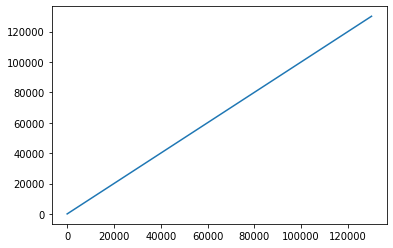

In [33]:
# Your code here
plt.plot(sorted(freq_dict.values))

### Experiment word clouds

In [17]:
wordcloud = WordCloud(background_color='white', stopwords = [], max_words=100).generate(corpus)            

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')

NameError: name 'WordCloud' is not defined

In [ ]:
from wordcloud import STOPWORDS # Note: this is the default option           
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Use word clouds with generate\_from\_frequencies. 
N.B.: retrieve the most words frequencies using a CountVectorizer

In [ ]:
# Your code here

### Drawing word clouds from classes


In [ ]:
# Your code here


# 1) Clustering algorithm: K-Means

**Let's start by the most famous and simple unsupervised algorithm: $k$-means!**
Look at [sklear documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
and apply it to your BoW matrix.


In [ ]:
from sklearn.cluster import KMeans
# your code here
kmeans = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(vectors)
# Getting clusters:
kmeans.cluster_centers_

### Clustering Analysis: 
1. **Qualtitative:**
    - Look at the most important words for each cluster
    - Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
2. **Quantitative:**
    - Compute cluster "purity": $p_j= |y^*_j|$, where $y^*_j$ is the most frequent (GT) label in cluster $C_j$ $\Rightarrow$ $p = \frac{1}{N}\sum\limits_j  p_j$
    - Compute [Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html) and [Adjusted Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score) 

# 2) Latent Semantic Analysis (LSA <=> SVD) 


**Remember the LSA factorziation**: 
$$ 
\begin{matrix} 
 & X  &\!\!\!\!\!=\!\!\!\!\!& U  & \Sigma & V^T \\
  & \textbf{t}_j   &  & \hat{ \textbf{d}_i} & &  \\
 & \downarrow  &  &\downarrow  & & \\
\textbf{d}_i \rightarrow 
&
\begin{pmatrix} 
x_{1,1} & \dots & x_{1,d} \\
\\
\vdots & \ddots & \vdots \\
\\
x_{N,1} & \dots & x_{N,d} \\
\end{pmatrix}
&
\!\!\!\!\!=\!\!\!\!\!
%&
%(\hat{ \textbf{t}_j}) \rightarrow
&
\begin{pmatrix} 
\begin{pmatrix} &  \textbf{u}_1 &  \end{pmatrix} \\
\vdots \\
\begin{pmatrix}  & \textbf{u}_k &  \end{pmatrix}
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\sigma_1 & \dots & 0 \\
\vdots & \ddots & \vdots \\
0 & \dots & \sigma_k \\
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\begin{pmatrix} \, \\ \, \\ \textbf{v}_1 \\ \, \\ \,\end{pmatrix} 
\dots
\begin{pmatrix} \, \\ \, \\ \textbf{v}_k \\ \, \\ \, \end{pmatrix}
\end{pmatrix}
\end{matrix}
$$

- Look at [SVD doc in skelarn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)
- Do the same qualitative/quantitative evaluation than with K-Means
- You can also use LSA as a pre-processing step for K-Means, *i.e.* running K-Means on $\boldsymbol{U}$ matrix above
    - N.B. : try without/with $\ell_2$ normalization of $\boldsymbol{U}$'s rows before running  K-Means
    - You can also benefit from LSA pre-processing for using [t-SNE visualization](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (see code below)


In [ ]:
# t-SNE from the U matrix computed by LSA
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca',n_iter=5000, verbose=2)
tsne_mat = tsne.fit_transform(U)

In [ ]:
NN2cluster = np.argmax(np.abs(vectors_SVDn), axis=0)
#import seaborn as sns
import matplotlib.cm as cm
cmap = cm.tab20
cmap = cm.get_cmap('hsv', 20) 
cmap = cm.get_cmap('jet', 20)
#cmap = cm.tab20

plt.figure(figsize=(15,10))
plt.scatter(tsne_mat[:,0],tsne_mat[:,1], c=Y, cmap=cmap, s=10)
plt.scatter(tsne_mat[NN2cluster[:],0],tsne_mat[NN2cluster[:],1], c='black', s=100)
#plt.scatter(tsne_mat[NN2cluster2[:],0],tsne_mat[NN2cluster2[:],1], c='red', s=100)
plt.colorbar(ticks=range(20))

# 3) Latent Dirichlet Allocation (LDA)

Perform the same experiments with LDA:
- LDA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html


**Start with a CountVectorizer**

In [ ]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
vectorizer = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df=0.95, min_df=2, max_features=1000)

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)
print(vectors.nnz / float(vectors.shape[0]))



## LDA-viz

In [ ]:
# pip install install pyldavis
from __future__ import print_function

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


pyLDAvis.sklearn.prepare(lda,vectors,vectorizer)

# Performances evaluation

**Compare the different approaches wrt three quantitative metrics.**